In [1]:
from TO_sim.get_rrrp import get_K_r_rp

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

from numba import njit
from numba.types import intc, CPointer, float64
from numba import cfunc, carray, jit
from scipy import LowLevelCallable

from scipy.integrate import quad
from scipy.optimize import brentq
import numpy as np

from tqdm.notebook import tqdm
import pandas as pd
from scipy import interpolate

In [3]:
def jit_integrand_function(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        values = carray(xx, n)
        return jitted_function(values[0], values[1])
    return LowLevelCallable(wrapped.ctypes)

def jit_integrand_function2(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)


def jit_integrand_function3(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)



@njit
def g(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

@njit
def g_sec(x,Or,Om):
    std = 1
    mean = -Or
    g = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

@jit_integrand_function2
def integrand_Rl(x, X,O_O,O_p,m):
    return g(x,O_O,O_p)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd(x, X,O_O,O_p,m):
    if m == 0:
        return 0
    else:
        return X/(2*(m*x**2+1/m))*g(x,O_O,O_p)

@jit_integrand_function2
def integrand_Rl2(x, X,O_pm,shift_O,m):
    return g_sec(x,O_pm+shift_O,O_pm)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd2(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x+O_pm+shift_O)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)
    # return 1/(2*(m*(x)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)


@jit_integrand_function2
def integrand_Rl3(x, X,O_pm,shift_O,m):
    return g(x,0,1)*np.sqrt(1-((x-O_pm-shift_O)/X)**2)


@jit_integrand_function2
def integrand_Rd3(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x-O_pm-shift_O)**2+1/m))*g(x,0,1)


def RP_diff(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=300)
        RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)

        return RP_l - RP_d - rp
    except:
        return np.nan


def RP_l(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
        return RP_l
    except:
        return np.nan


def get_K_r_rp_full(m):
    Xs1 = np.logspace(-15,-3,2000)
    Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]

    R_ls = []
    R_drs = []


    for X in Xs:
        a = 1/np.sqrt(X*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)

        omega_p = b*X
        R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
        R_ls.append(R_l)
        R_drs.append(R_dr)


    R0 = np.array(R_ls)
    RD = 2*np.array(R_drs)
    R = R0 -RD
    KK = 1/(R/Xs)
    K_min_arg = np.argmin(KK)

    K_d = KK[:K_min_arg]
    K_u = KK[K_min_arg:]
    r_d = Xs[:K_min_arg]/K_d
    r_u = Xs[K_min_arg:]/K_u
    R_0d = R0[:K_min_arg]
    R_0u = R0[K_min_arg:]
    R_dd = -RD[:K_min_arg]
    R_du = -RD[K_min_arg:]

    R_u = R_0u + R_du
    R_d = R_0d + R_dd
    K_start = KK[K_min_arg]
    Xsu = Xs[K_min_arg:]
    Xsd = Xs[:K_min_arg]

    a = 1/np.sqrt(Xsu*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPS = b*Xsu


    a = 1/np.sqrt(Xsd*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPSd = b*Xsd


    RP1_d = []
    RP1_u = []
    RPl_d = []
    RPl_u = []
    K1p = []

    for K, r, r0, OP in zip(K_u, R_u, R_0u, OPS):
        # 1. 적당한 간격으로 샘플
        rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
        diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])


        # 2. sign change 구간 찾기 (교점 후보)
        sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]

        try:
            # 첫 번째 교점
            i1 = sign_change[0]
            if len(sign_change) == 1:
                rp_left = 0
                RP1_d.append(0)
                RPl_d.append(0)
                
            else:
                rp_left = brentq(RP_diff, rps[i1], rps[i1+1], args=(K, r0, OP, m))
                RP1_d.append(rp_left)
                RPl_d.append(RP_l(rp_left, K, r0, OP, m))


                
            # 두 번째 교점
            i2 = sign_change[-1]
            rp_right = brentq(RP_diff, rps[i2-1], rps[i2+1], args=(K, r0, OP, m))

            RP1_u.append(rp_right)
            RPl_u.append(RP_l(rp_right, K, r0, OP, m))
            K1p.append(K)
        except:
            K1p.append(K)
            RP1_d.append(np.nan)
            RP1_u.append(np.nan)
            RPl_d.append(np.nan)
            RPl_u.append(np.nan)


    K1p = np.array(K1p)
    RP1_u = np.array(RP1_u)
    RPl_u = np.array(RPl_u)
    RP1_d = np.array(RP1_d)
    RPl_d = np.array(RPl_d)


    arg, = np.where(RP1_u<1e-13)
    K1p[arg] = np.nan
    RPl_u[arg] = np.nan
    RP1_u[arg] = np.nan
    RPl_d[arg] = np.nan
    RP1_d[arg] = np.nan
    return R_u,R_0u,R_d,R_0d,RP1_u,RPl_u,RP1_d,RPl_d,K1p,K_start


In [4]:
m = 6

In [5]:
Xs1 = np.logspace(-15,-3,2000)
Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]

R_ls = []
R_drs = []


for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls.append(R_l)
    R_drs.append(R_dr)


R0 = np.array(R_ls)
RD = 2*np.array(R_drs)
R = R0 -RD
KK = 1/(R/Xs)
K_min_arg = np.argmin(KK)

K_d = KK[:K_min_arg]
K_u = KK[K_min_arg:]
r_d = Xs[:K_min_arg]/K_d
r_u = Xs[K_min_arg:]/K_u
R_0d = R0[:K_min_arg]
R_0u = R0[K_min_arg:]
R_dd = -RD[:K_min_arg]
R_du = -RD[K_min_arg:]

R_u = R_0u + R_du
R_d = R_0d + R_dd
K_start = KK[K_min_arg]
Xsu = Xs[K_min_arg:]
Xsd = Xs[:K_min_arg]

a = 1/np.sqrt(Xsu*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPS = b*Xsu


a = 1/np.sqrt(Xsd*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPSd = b*Xsd

In [6]:
F_K_OPS = interpolate.interp1d(K_u,OPS)

In [7]:
K_s = np.arange(3,10,1)
OPS_s = F_K_OPS(K_s)


(0.0, 1.0)

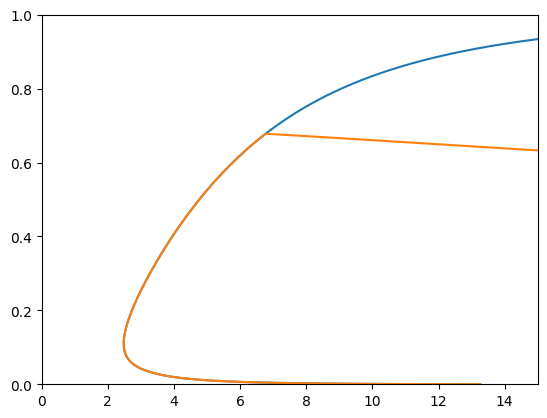

In [8]:
plt.plot(KK,R)


# for K in K_s:
R_ls2 = []
R_drs2 = []
K_start = 6.77
omega_p = F_K_OPS(K_start)
K_ = np.where(KK>K_start)[0][0]
Xs_u = Xs[K_:]

for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    omega = b*X
    omega_p = min(omega,F_K_OPS(K_start))
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls2.append(R_l)
    R_drs2.append(R_dr)


R02 = np.array(R_ls2)
RD2 = 2*np.array(R_drs2)
R2 = R02 -RD2
KK2 = 1/(R2/Xs_u)
# plt.plot(KK2,R2)
plt.plot(KK2,R2)
plt.xlim(0,15)
plt.ylim(0,1)



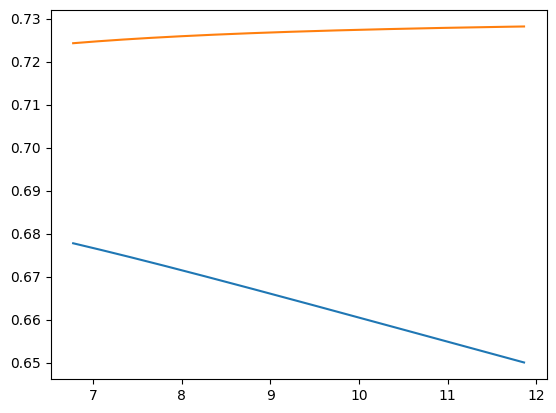

In [9]:
cond = R2 > 0.65
K_con = 1/(R2/Xs)
cond2 = cond & (K_con>K_start)
K_con2 = K_con[cond2]
# Xs[cond]

plt.plot(K_con2,R2[cond2])
plt.plot(K_con2,R02[cond2])


In [10]:
def RP_diff(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=300)
        RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)

        return RP_l - RP_d - rp
    except:
        return np.nan

In [11]:
F_KR = interpolate.interp1d(K_con2,R2[cond2])
F_KR0 = interpolate.interp1d(K_con2,R02[cond2])

In [423]:
OP = omega_p
K = K_start
r0 = F_KR0(K)
rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])
sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]
plt.plot(rps,diffs)
plt.axvline(rps[sign_change[0]])
# plt.plot(sign_change)

ValueError: A value (6.77) in x_new is below the interpolation range's minimum value (6.773645527999554).

In [12]:

def RP_diff(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=300)
        RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)

        return RP_l - RP_d - rp
    except:
        return np.nan


def RP_l(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
        return RP_l
    except:
        return np.nan



In [13]:
rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])


NameError: name 'r0' is not defined

In [71]:

RP1_d = []
RP1_u = []
RPl_d = []
RPl_u = []
K1p = []
l_num = 0
r_num = 0
for K, r, r0 in zip(K_con2, R2[cond2], R02[cond2]):
    OP = omega_p
    # 1. 적당한 간격으로 샘플
    rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
    diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])

    # 2. sign change 구간 찾기 (교점 후보)
    sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]
    try:
        # 첫 번째 교점
        K1p.append(K)
        i1 = sign_change[0]
        if len(sign_change) == 1:
            rp_left = 0
            RP1_d.append(np.nan)
            RPl_d.append(np.nan)

        else:
            rp_left = brentq(RP_diff, rps[i1], rps[i1+1], args=(K, r0, OP, m),)
            RP1_d.append(rp_left)
            RPl_d.append(RP_l(rp_left, K, r0, OP, m))

            
        # 두 번째 교점
        i2 = sign_change[-1]
        try:
            rp_right = brentq(RP_diff, rps[i2-1], rps[i2+1], args=(K, r0, OP, m))
            RP1_u.append(rp_right)
            try:
                RPl_u.append(RP_l(rp_right, K, r0, OP, m))
            except:
                RPl_u.append(np.nan)
        except:
            RP1_u.append(np.nan)
            RPl_u.append(np.nan)
    except:
        K1p.append(K)
        RP1_d.append(np.nan)
        RP1_u.append(np.nan)

        RPl_d.append(np.nan)
        RPl_u.append(np.nan)


K1p = np.array(K1p)
RP1_u = np.array(RP1_u)
RPl_u = np.array(RPl_u)
RP1_d = np.array(RP1_d)
RPl_d = np.array(RPl_d)


arg, = np.where(RP1_u<1e-13)
K1p[arg] = np.nan
RPl_u[arg] = np.nan
RP1_u[arg] = np.nan
RPl_d[arg] = np.nan
RP1_d[arg] = np.nan

In [16]:
DATA = np.load('DATA_hys.npz')
Ks_ = np.arange(0,15,0.01)

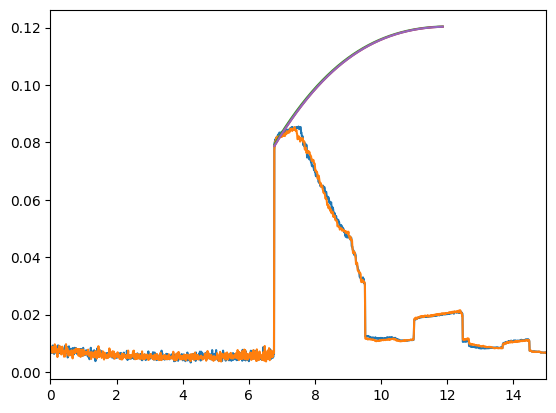

In [72]:
# plt.plot(Ks_,DATA['R'])
plt.plot(Ks_,DATA['rp'])
plt.plot(Ks_,DATA['rm'])

plt.plot(K_con2,RPl_u)

plt.xlim(0,15)

plt.plot(K_con2,RP1_u)
plt.plot(K_con2,RP1_u)

In [413]:
rp = RPl_u[0]

In [19]:
K_ = np.linspace(0,15,10001)
Ru,R0u,rp_u,rpl_u = get_K_r_rp(m,K_)

In [20]:
a = 1 / np.sqrt(Ks_[952]*DATA['R'][952] * m)
b = 4 / np.pi * a - 0.3056 * a**3
b = np.where(a>1.193,1,b)
OP_ = max(b * Ks_[952]*DATA['R'][952], 0)

In [21]:
Ks_[952]*DATA['R'][952]

8.220730570559148

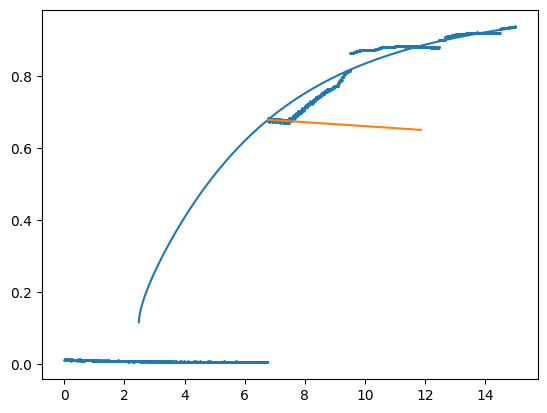

In [73]:

plt.scatter(Ks_,DATA['R'],s=1)
plt.plot(K_,Ru)
plt.plot(K_con2,R2[cond2])

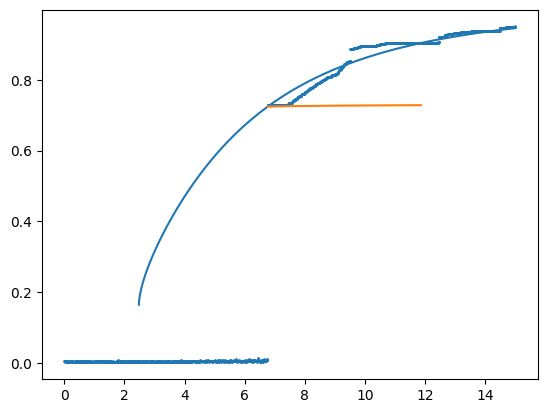

In [74]:
plt.scatter(Ks_,DATA['R0'],s=1)
plt.plot(K_,R0u)
plt.plot(K_con2,R02[cond2])

(0.0, 15.0)

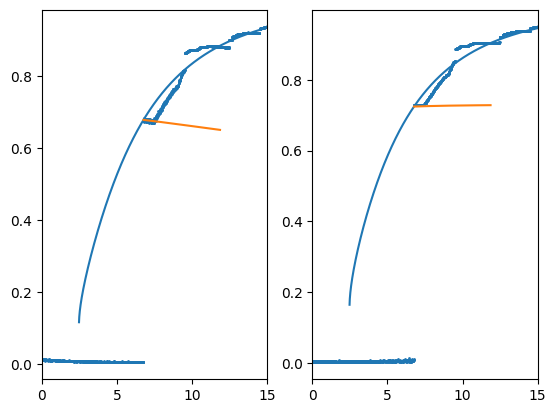

In [23]:
plt.subplot(121)
plt.scatter(Ks_,DATA['R'],s=1)
plt.plot(K_,Ru)
plt.plot(K_con2,R2[cond2])

# plt.axvline(K_new_start)
plt.xlim(0,15)

plt.subplot(122)
plt.scatter(Ks_,DATA['R0'],s=1)
plt.plot(K_,R0u)
plt.plot(K_con2,R02[cond2])
plt.xlim(0,15)

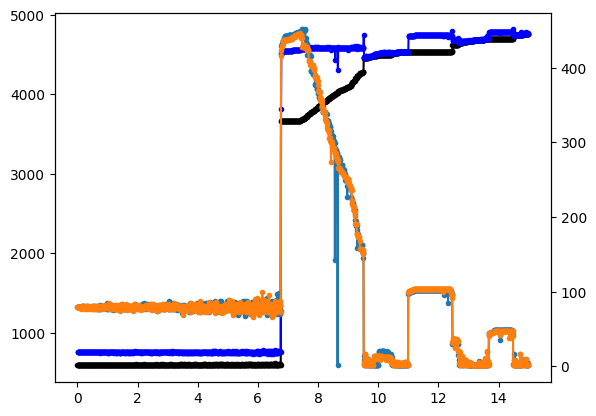

In [330]:

plt.plot(Ks_,DATA['N0s'],'k.-')
plt.plot(Ks_[1:],DATA['N0s'][1:] + DATA['NPs'][:-1] +DATA['NMs'][:-1] ,'b.-')

plt.twinx()
plt.plot(Ks_,DATA['NPs'],'.-')
plt.plot(Ks_,DATA['NMs'],'.-')


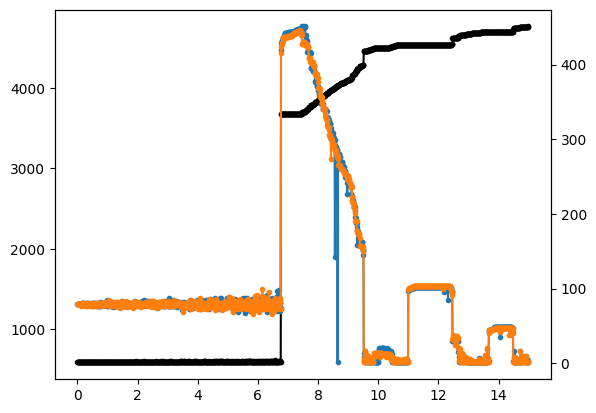

In [264]:

plt.plot(Ks_,DATA['N0s'],'k.-')
plt.twinx()
plt.plot(Ks_,DATA['NPs'],'.-')
plt.plot(Ks_,DATA['NMs'],'.-')


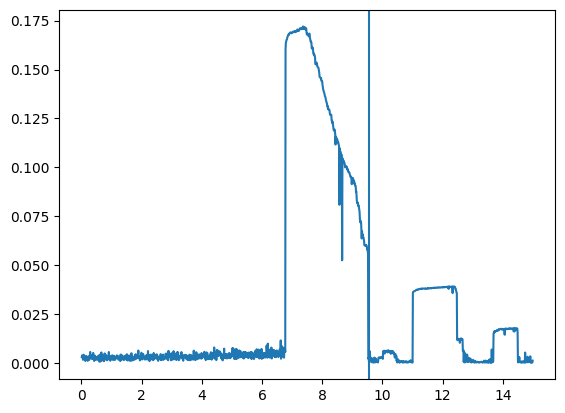

In [261]:
plt.plot(Ks_[1:],DATA['rpl'][:-1] + DATA['rml'][:-1])
# plt.plot(Ks_,DATA['R0'])
plt.axvline(K_new_start)

In [28]:
Ks_[677]

6.7700000000000005

In [75]:
# rp = RP1_u[~np.isnan(RP1_u)][0]
F_rp = interpolate.interp1d(K_,rp_u,kind='linear')
F_r0 = interpolate.interp1d(K_,R0u,kind='linear')
rp = F_rp(Ks_[677])
r0 = F_r0(Ks_[677])

In [588]:
RP1_u[~np.isnan(RP1_u)][0] , rp

(0.0786235592842106, array(0.0787131))

In [32]:
a = 1 / np.sqrt(K_start * rp * m)
b = 4 / np.pi * a - 0.3056 * a**3
if a > 1.193: b = 1
b = min(b, 1)
OPs = max(b * K_start * rp, 0)

delta_p = (m * K_start**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K_start**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))


In [33]:
OPs

0.3509635538473547

In [34]:
RP_ls = np.zeros(len(K_con2))
RP_ds = np.zeros(len(K_con2))
delta_Ps = []
K_con2_ = []
for i,K in enumerate(K_con2):

	delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))
	delta_Ps.append(delta_P)
	K_con2_.append(K)
	if delta_P-OPs<0:
		RP_ls[i], _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=300)
		RP_ds[i], _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)
	else:
		K_new_start = K
		OP_new = delta_P + OPs
		delta_p = delta_P
		break

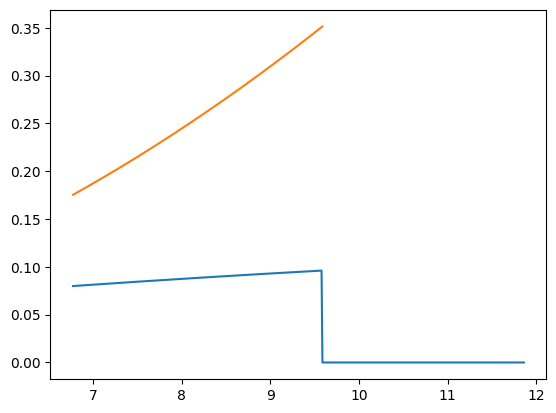

In [35]:
plt.plot(K_con2,RP_ls+RP_ds)
plt.plot(K_con2_,delta_Ps)

C:\Users\kim9y\AppData\Local\Temp\ipykernel_14656\1188987638.py:15: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)


(0.0, 1.0)

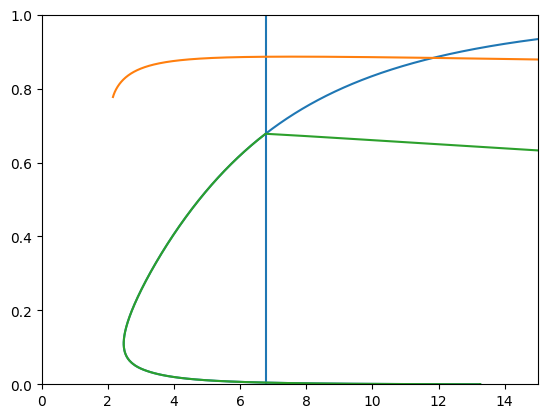

In [403]:
plt.plot(KK,R)
# for K in K_s:
R_ls2 = []
R_drs2 = []
K_start = 6.77

K_2 = np.where(KK>K_new_start)[0][0]
OP2 = OP + 0.57
for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    omega = b*X
    omega_p = OP2
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls2.append(R_l)
    R_drs2.append(R_dr)


R03 = np.array(R_ls2)
RD3 = 2*np.array(R_drs2)
R3 = R03 -RD3
KK3 = 1/(R3/Xs_u2)
# plt.plot(KK2,R2)
plt.axvline(K_new_start)
plt.plot(KK3,R3)
plt.plot(KK2,R2)
plt.xlim(0,15)
plt.ylim(0,1)



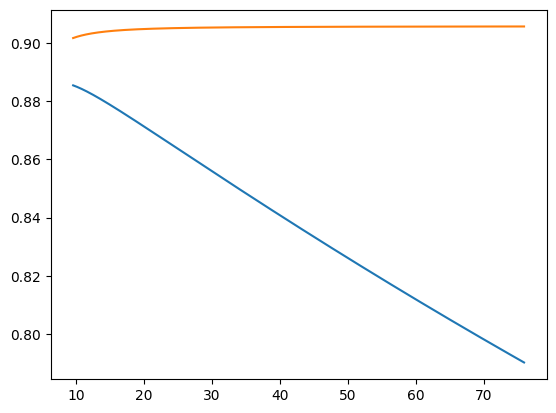

In [302]:
cond = R3 > 0.55
K_con = 1/(R3/Xs)
cond3 = cond & (K_con>K_new_start)
K_con3 = K_con[cond3]
# Xs[cond]

plt.plot(K_con3,R3[cond3])
plt.plot(K_con3,R03[cond3])


(0.0, 15.0)

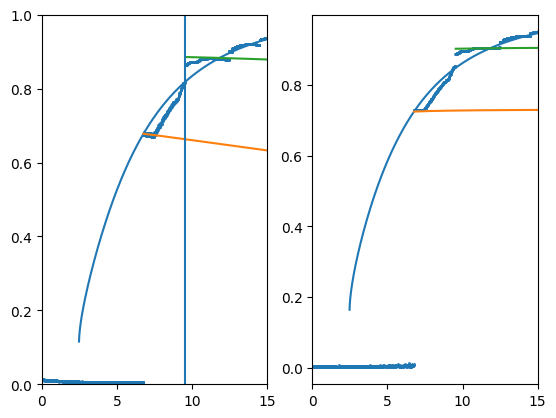

In [303]:
plt.subplot(121)
plt.scatter(Ks_,DATA['R'],s=1)
plt.plot(K_,Ru)
plt.plot(K_con2,R2[cond2])
plt.plot(K_con3,R3[cond3])


plt.axvline(K_new_start)
plt.xlim(0,15)
plt.ylim(0,1)

plt.subplot(122)
plt.scatter(Ks_,DATA['R0'],s=1)
plt.plot(K_,R0u)
plt.plot(K_con2,R02[cond2])

plt.plot(K_con3,R03[cond3])

plt.xlim(0,15)

In [309]:

RP1_d2 = []
RP1_u2 = []
RPl_d2 = []
RPl_u2 = []
K2p = []
l_num = 0
r_num = 0
for K, r, r0 in zip(K_con3, R3[cond3], R03[cond3]):
    
    # 1. 적당한 간격으로 샘플
    rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) , 100)]
    diffs = np.array([RP_diff(rp, K, r0, OP2, m) for rp in rps])

    # 2. sign change 구간 찾기 (교점 후보)
    sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]
    try:
        # 첫 번째 교점
        K2p.append(K)
        i1 = sign_change[0]
        if len(sign_change) == 1:
            rp_left = 0
            RP1_d2.append(np.nan)
            RPl_d2.append(np.nan)

        else:
            rp_left = brentq(RP_diff, rps[i1], rps[i1+1], args=(K, r0, OP2, m),)
            RP1_d2.append(rp_left)
            RPl_d2.append(RP_l(rp_left, K, r0, OP2, m))

            
        # 두 번째 교점
        i2 = sign_change[-1]
        try:
            rp_right = brentq(RP_diff, rps[i2-1], rps[i2+1], args=(K, r0, OP2, m))
            RP1_u2.append(rp_right)
            try:
                RPl_u2.append(RP_l(rp_right, K, r0, OP2, m))
            except:
                RPl_u2.append(np.nan)
        except:
            RP1_u2.append(np.nan)
            RPl_u2.append(np.nan)
    except:
        K2p.append(K)
        RP1_d2.append(np.nan)
        RP1_u2.append(np.nan)

        RPl_d2.append(np.nan)
        RPl_u2.append(np.nan)


K2p = np.array(K2p)
RP1_u2 = np.array(RP1_u2)
RPl_u2 = np.array(RPl_u2)
RP1_d2 = np.array(RP1_d2)
RPl_d2 = np.array(RPl_d2)


arg, = np.where(RP1_u2<1e-13)
K2p[arg] = np.nan
RPl_u2[arg] = np.nan
RP1_u2[arg] = np.nan
RPl_d2[arg] = np.nan
RP1_d2[arg] = np.nan

C:\Users\kim9y\AppData\Local\Temp\ipykernel_14656\2487331842.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=300)
C:\Users\kim9y\AppData\Local\Temp\ipykernel_14656\2487331842.py:11: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=300)


In [70]:
plt.plot(K2p,RP1_u2)

NameError: name 'K2p' is not defined

ValueError: x and y must have same first dimension, but have shapes (1,) and (10001,)

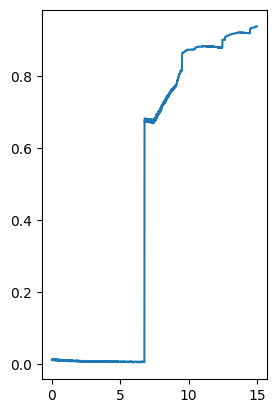

In [283]:
plt.subplot(121)
plt.plot(Ks_,DATA['R'])
plt.plot(K_,Ru)
plt.plot(K_con2,R2[cond2])
plt.plot(K_con2,R3[cond2])
plt.xlim(0,15)

plt.subplot(122)
plt.plot(Ks_,DATA['R0'])
plt.plot(K_,R0u)
plt.plot(K_con2,R02[cond2])
plt.plot(K_con2,R03[cond2])
plt.xlim(0,15)

In [ ]:
RP_ls = np.zeros(len(K_con2))
RP_ds = np.zeros(len(K_con2))
delta_Ps = []
K_con2_ = []
for i,K in enumerate(K_con2):

	delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))
	delta_Ps.append(delta_P)
	K_con2_.append(K)
	if delta_P-OPs<0:
		RP_ls[i], _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=300)
		RP_ds[i], _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)
	else:
		K_new_start = K
		OP_new = delta_P + OPs
		delta_p = delta_P
		break

In [41]:
OP+delta_P + OPs

1.8059747248633053

In [48]:
delta_P + OPs

0.7022252820399857

In [50]:
quad(g,OP,OP+delta_P + OPs,args=(0,1),limit=300)

(0.09938977687502859, 1.1034481869901369e-15)

In [52]:
from scipy.special import erf
from scipy.integrate import quad
def F(x,mu,sigma):
	return x*np.exp(-(x-mu)**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)
quad(F,OP,OP+delta_P + OPs,args=(0,1),limit=300)

(0.1388497519442414, 1.541541915719884e-15)

In [55]:
(np.exp(-(OP)**2/(2)) -np.exp(-(OP+delta_P + OPs)**2/(2)) )/np.sqrt(2*np.pi)

0.13884975194424143

In [228]:
OP + OP_new

1.8085734737127641

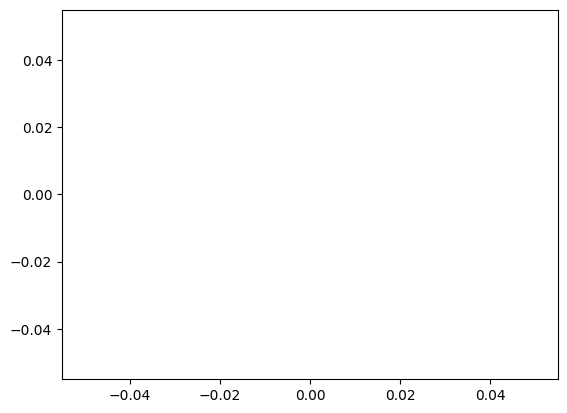

In [310]:
plt.plot(K_con3,RPl_u2)


In [311]:
R03[cond3]

array([0.90176034, 0.90176613, 0.90177191, ..., 0.90574001, 0.90574002,
       0.90574004])

In [ ]:
rp = F_rp(Ks_[677])
r0 = F_r0(Ks_[677])

a = 1 / np.sqrt(K_start * rp * m)
b = 4 / np.pi * a - 0.3056 * a**3
if a > 1.193: b = 1
b = min(b, 1)
OPs = max(b * K_start * rp, 0)

In [329]:
RP_l2s = np.zeros(len(K_con3))
RP_d2s = np.zeros(len(K_con3))
OP2 = OP + 0.57

for i,K in enumerate(K_con3):

	delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP2**2 + 1)) + (K**2 * rp**2) / (4 * OP2 * (4 * m**2 * OP2**2 + 1))
	if delta_P-OPs<0:
		RP_l2s[i], _ = quad(integrand_Rl3, OP2, OP2 + delta_P + OPs, args=(K * rp, OP2, delta_P, m), limit=300)
		RP_d2s[i], _ = quad(integrand_Rd, OP2 + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)
	else:
		print(K)
		K_new_start2 = K
		OP_new2 = delta_P + OPs
		delta_p2 = delta_P
		break

15.681397510359552


In [ ]:
RP_l2s = np.zeros(len(K_con3))
RP_d2s = np.zeros(len(K_con3))
OP2 = OP + 0.57

RP = RP_l2s + RP_d2s
RP[0] = rp
for i,K in enumerate(K_con3):
	delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP2**2 + 1)) + (K**2 * rp**2) / (4 * OP2 * (4 * m**2 * OP2**2 + 1))
	
	if delta_P-OPs<0:
		RP_l2s[i], _ = quad(integrand_Rl3, OP2, OP2 + delta_P + OPs, args=(K * rp, OP2, delta_P, m), limit=300)
		RP_d2s[i], _ = quad(integrand_Rd, OP2 + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=300)
	else:
		print(K)
		K_new_start2 = K
		OP_new2 = delta_P + OPs
		delta_p2 = delta_P
		break

(0.0, 15.0)

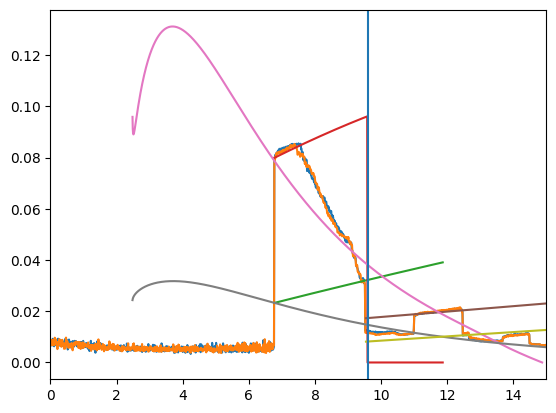

In [596]:
# plt.plot(Ks_,DATA['R'])
plt.plot(Ks_,DATA['rp'])
plt.plot(Ks_,DATA['rm'])


# plt.plot(K_,Ru)
plt.plot(K_con2,(R02[cond2]-R2[cond2])/2)
# plt.plot(K_con2,RPl_u)
plt.plot(K_con2,RP_ls+RP_ds)

plt.plot(K_con3,RPl_u2)
plt.plot(K_con3,RP_l2s+RP_d2s)


plt.plot(K_,rp_u)
plt.plot(K_,(R0u -Ru)/2)
plt.plot(K_con3,(R03[cond3]-R3[cond3])/2)
plt.axvline(K_new_start)

plt.xlim(0,15)

In [207]:
OPs

0.3522494369295049

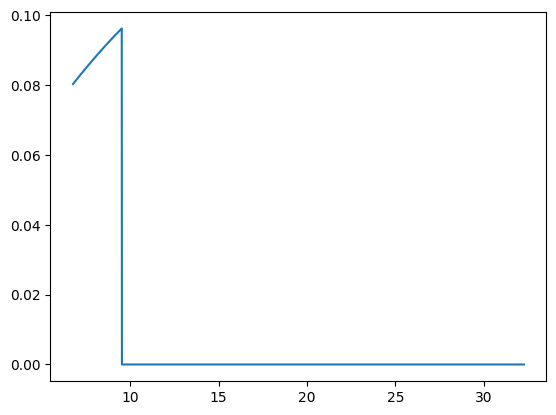

In [220]:
plt.plot(K_con2,RP_ls+RP_ds)

In [134]:
a = 1 / np.sqrt(K_con * RP1_u * m)
b = 4 / np.pi * a - 0.3056 * a**3
b = np.where(a>1.193,1,b)
OPs = b * K_con * RP1_u

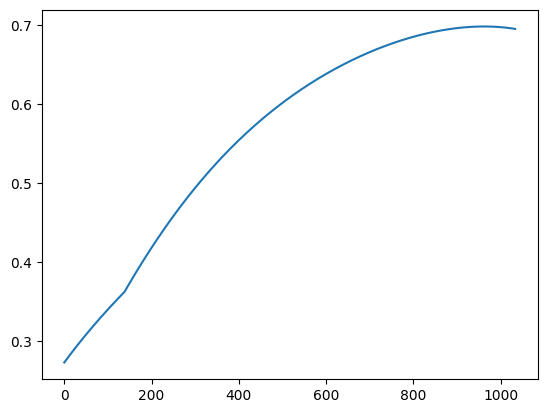

In [136]:
plt.plot(OPs)

ValueError: x and y must have same first dimension, but have shapes (1,) and (10001,)

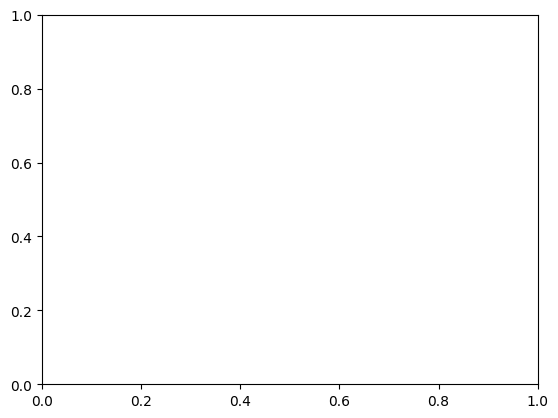

In [417]:
plt.plot(K_,rpl_u)
plt.plot(K_,rp_u)
plt.plot(K_con2,RP1_u)
plt.plot(K_con2,RP1_d)

plt.plot(K_con2,RP_ls+RP_ds)

plt.ylim(0,)
# plt.plot(K1p,RP1_u)
plt.xlim(0,25)
plt.axvline(5)
plt.axvline(6)

In [12]:

RP1_d = []
RP1_u = []
RPl_d = []
RPl_u = []
K1p = []

for K, r, r0, OP in zip(K_u, R_u, R_0u, OPS):
    # 1. 적당한 간격으로 샘플
    rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
    diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])


    # 2. sign change 구간 찾기 (교점 후보)
    sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]

    try:
        # 첫 번째 교점
        i1 = sign_change[0]
        if len(sign_change) == 1:
            rp_left = 0
            RP1_d.append(0)
            RPl_d.append(0)
            
        else:
            rp_left = brentq(RP_diff, rps[i1], rps[i1+1], args=(K, r0, OP, m))
            RP1_d.append(rp_left)
            RPl_d.append(RP_l(rp_left, K, r0, OP, m))


            
        # 두 번째 교점
        i2 = sign_change[-1]
        rp_right = brentq(RP_diff, rps[i2-1], rps[i2+1], args=(K, r0, OP, m))

        RP1_u.append(rp_right)
        RPl_u.append(RP_l(rp_right, K, r0, OP, m))
        K1p.append(K)
    except:
        K1p.append(K)
        RP1_d.append(np.nan)
        RP1_u.append(np.nan)
        RPl_d.append(np.nan)
        RPl_u.append(np.nan)


K1p = np.array(K1p)
RP1_u = np.array(RP1_u)
RPl_u = np.array(RPl_u)
RP1_d = np.array(RP1_d)
RPl_d = np.array(RPl_d)


arg, = np.where(RP1_u<1e-13)
K1p[arg] = np.nan
RPl_u[arg] = np.nan
RP1_u[arg] = np.nan
RPl_d[arg] = np.nan
RP1_d[arg] = np.nan

In [ ]:
m = 6
R_u,R_0u,R_d,R_0d,RP1_u,RPl_u,RP1_d,RPl_d,K1p,K_start = get_K_r_rp_full(m)

In [29]:
R_u2,R_0u2,R_d2,R_0d2,RP1_u2,RPl_u2,RP1_d2,RPl_d2,K1p2,K_start2 = get_K_r_rp_full(m)


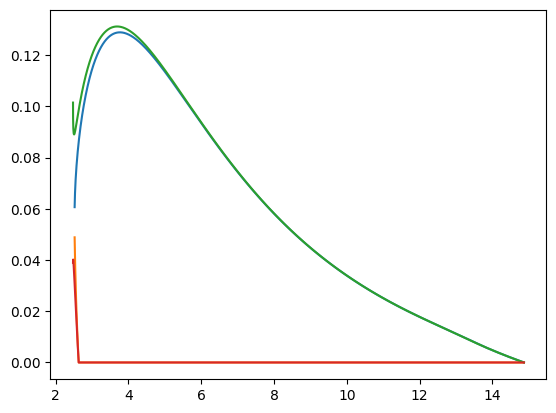

In [30]:
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)

plt.plot(K1p2,RP1_u2)
plt.plot(K1p2,RP1_d2)

In [31]:
import sympy as sp

In [49]:
K,r0,theta_i,rp,omega_p,t = sp.symbols('K,r0,theta_i,r_{(+)},\omega_{(+)},t',real=True)
phi_p, phi_m = sp.symbols('phi_+, phi_-',real=True)

In [57]:
F = -K*r0*sp.sin(theta_i) + K*rp*sp.sin(phi_p - theta_i) + K*rp*sp.sin(-phi_p- theta_i)
FF = F.subs(theta_i,theta_i+phi_p)
FF.subs(phi_p,omega_p*t - sp.pi/2)


K*r0*cos(\omega_{(+)}*t + theta_i) - K*r_{(+)}*sin(theta_i) + K*r_{(+)}*sin(2*\omega_{(+)}*t + theta_i)

In [64]:
cons = np.load('DATA_hys cluster.npz',allow_pickle=True)
avg_dthetas = np.load('DATA_avg_theta.npz')

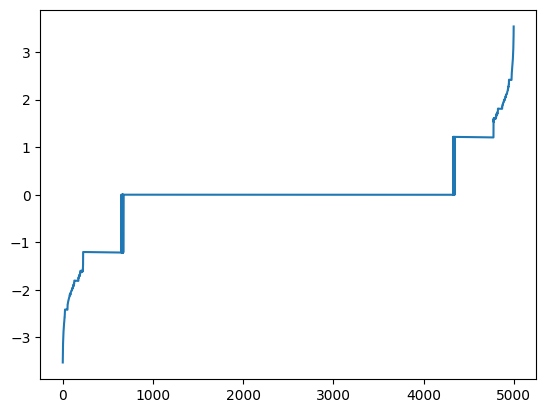

In [ ]:
Vs = np.array(avg_dthetas['vs'])


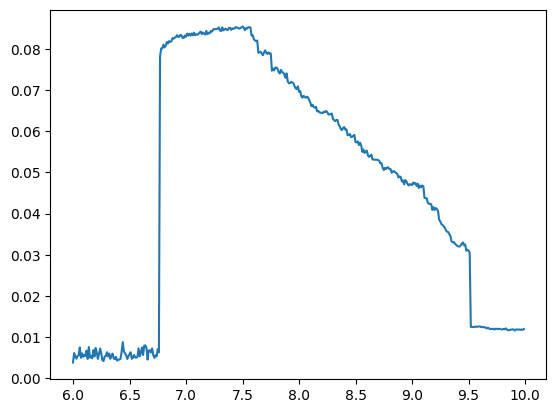

In [56]:
# plt.plot(Ks_[600:1000],DATA['R'][600:1000])
plt.plot(Ks_[600:1000],DATA['rp'][600:1000])

In [59]:
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
N = 5000

In [60]:
seed = 11
_,omega,Kc = Q_Normal(N,0,1,seed=seed)
omega = omega - np.mean(omega)

In [61]:
K_start

6.77

In [65]:
c_ss = cons['c_s']

In [66]:
types = []
Ns = np.arange(N)
type_ = np.nan * np.ones(N)
for i, c_s in enumerate(c_ss):
    _0 = Ns[c_s['0']]
    _p = Ns[c_s['+l']]
    _m = Ns[c_s['-l']]
    TY = type_.copy()
    TY[_0] = 0
    TY[_p] = +1
    TY[_m] = -1
    types.append(TY)
# types를 color로 mapping하는 colormap을 만듭니다.
from matplotlib.colors import ListedColormap

# 예시: type이 -1, 0, +1이므로, 각각 파랑, 회색, 빨강으로 지정
type_colors = {-1: 'blue', 0: 'grey', 1: 'red'}

# N개에 대해, 각 type 값에 맞는 색상을 리스트로 변환
def map_types_to_colors(type_array):
    return [type_colors.get(t, 'black') for t in type_array]

# types 리스트 전체를 색상 리스트로 변환
# (만약 각 types가 shape (N,)라면 목록 생성, shape가 다르면 적절히 수정)
types_colors = [map_types_to_colors(TY) for TY in types]


(-3.0, 0.0)

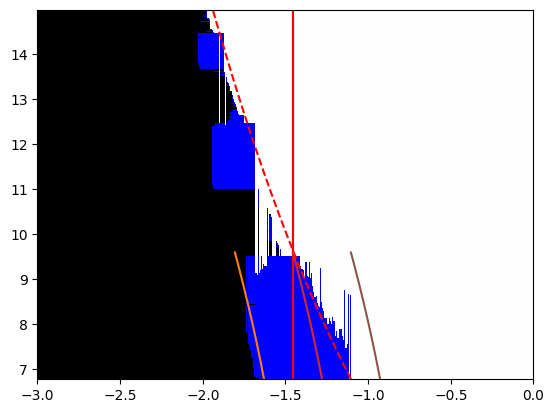

In [80]:
plt.pcolormesh(omega,Ks_[677:],np.array(types[677:]),cmap='bwr')
plt.gca().set_facecolor('k')
plt.axvline(OP+delta_p,color='b')
plt.axvline(-(OP+delta_p),color='r')
plt.axvline(OP+delta_P,color='b')
plt.axvline(-(OP+delta_P),color='r')
plt.plot(F_K_OPS(Ks_[677:]),Ks_[677:],'b--')
plt.plot(-F_K_OPS(Ks_[677:]),Ks_[677:],'r--')
plt.plot(OP + np.array(delta_Ps)+OPs,K_con2_)
plt.plot(-(OP + np.array(delta_Ps)+OPs),K_con2_)


plt.plot(OP + np.array(delta_Ps),K_con2_)
plt.plot(-(OP + np.array(delta_Ps)),K_con2_)

plt.plot(OP + np.array(delta_Ps)-OPs,K_con2_)
plt.plot(-(OP + np.array(delta_Ps)-OPs),K_con2_)
plt.xlim(-3,0)

(0.0, 3.0)

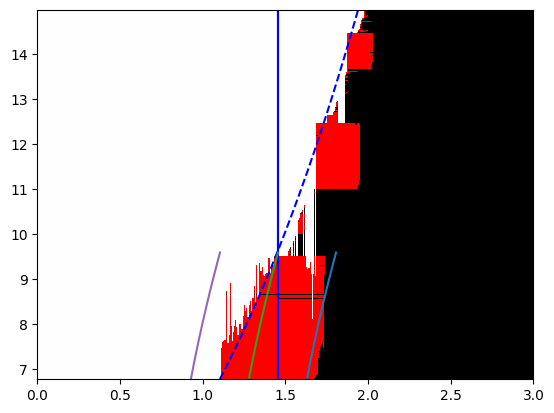

In [69]:
plt.pcolormesh(omega,Ks_[677:],np.array(types[677:]),cmap='bwr')
plt.gca().set_facecolor('k')
plt.axvline(OP+delta_p,color='b')
plt.axvline(-(OP+delta_p),color='r')
plt.axvline(OP+delta_P,color='b')
plt.axvline(-(OP+delta_P),color='r')
plt.plot(F_K_OPS(Ks_[677:]),Ks_[677:],'b--')
plt.plot(-F_K_OPS(Ks_[677:]),Ks_[677:],'r--')
plt.plot(OP + np.array(delta_Ps)+OPs,K_con2_)
plt.plot(-(OP + np.array(delta_Ps)+OPs),K_con2_)


plt.plot(OP + np.array(delta_Ps),K_con2_)
plt.plot(-(OP + np.array(delta_Ps)),K_con2_)

plt.plot(OP + np.array(delta_Ps)-OPs,K_con2_)
plt.plot(-(OP + np.array(delta_Ps)-OPs),K_con2_)
plt.xlim(0,3)

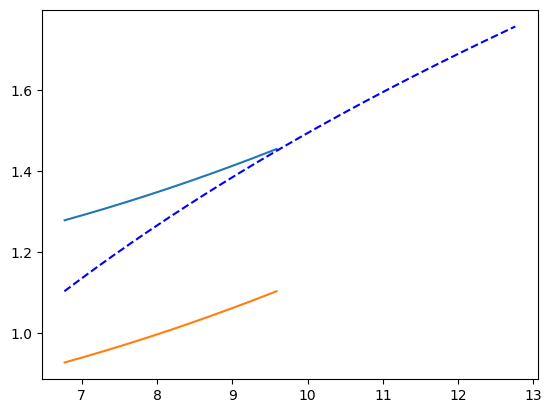

In [523]:
plt.plot(K_con2_,OP + np.array(delta_Ps))
plt.plot(K_con2_,OP + np.array(delta_Ps)-OPs)
plt.plot(Ks_[677:677+600],F_K_OPS(Ks_[677:677+600]),'b--')


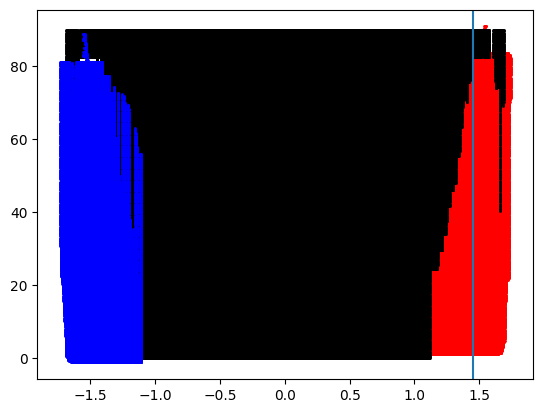

In [ ]:
for i in range(300):
	c = cons['c_s'][677+i]
	c0 = c['0']
	cp = c['+l']
	cm = c['-l']
	plt.scatter(omega[c0],Vs[677+i][c0]+0.3*i,s=1,color='k')
	plt.scatter(omega[cp],Vs[677+i][cp]+0.3*i,s=1,color='r')
	plt.scatter(omega[cm],Vs[677+i][cm]+0.3*i,s=1,color='b')
plt.plot(F_K_OPS(Ks_[677:677+300]),Ks_[677:677+300],'k--')
plt.plot(-F_K_OPS(Ks_[677:677+300]),Ks_[677:677+300],'k--')
plt.axvline(OP+delta_p)

In [ ]:
plt.scatter(omega,Vs[951],s=1)
plt.scatter(omega,Vs[952]+0.2,s=1)

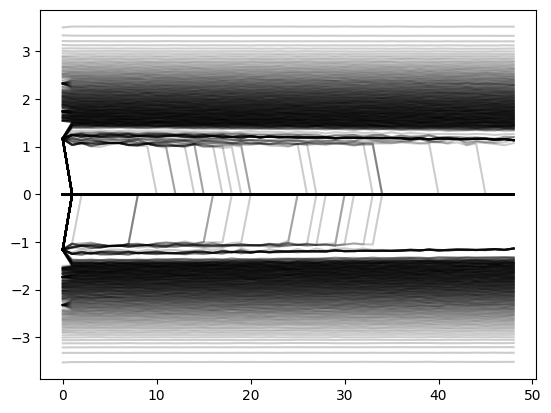

In [376]:
plt.plot(Vs[951:1000],alpha=0.2,color='k');
# plt.scatter(np.arange(5000),Vs[710+10],s=1)

In [ ]:
F_rp = interpolate.interp1d(K_,rp_u,kind='linear')
F_rp(Ks_[677])

OP_ = 4/np.pi*np.sqrt(Ks_[677]*DATA['R'][677]/m) - 0.3056/np.sqrt(Ks_[677]*DATA['R'][677]*m**3)
delta_P = (m * Ks_[677]**2 * DATA['R0'][677] * F_rp(Ks_[677])) / (2 * (m**2 * OP_**2 + 1)) + (Ks_[677]**2 * F_rp(Ks_[677])**2) / (4 * OP_ * (4 * m**2 * OP_**2 + 1))

In [ ]:
F_rp(Ks_[677])

array(0.0787131)

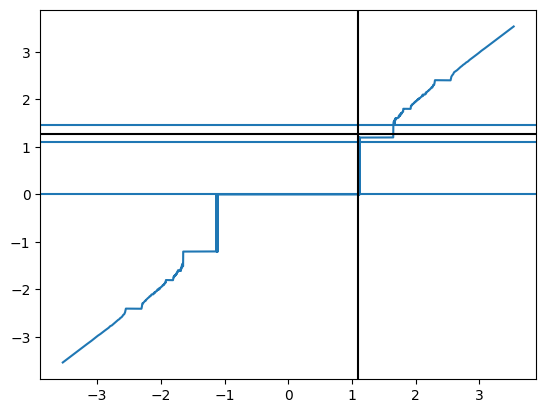

In [584]:
plt.plot(omega,avg_dthetas['vs'][677])
plt.axhline(0)
plt.axhline(OP+delta_p)
plt.axhline(OP+delta_P,color='k')
plt.axhline(OP)
plt.axvline(OP_,color='k')

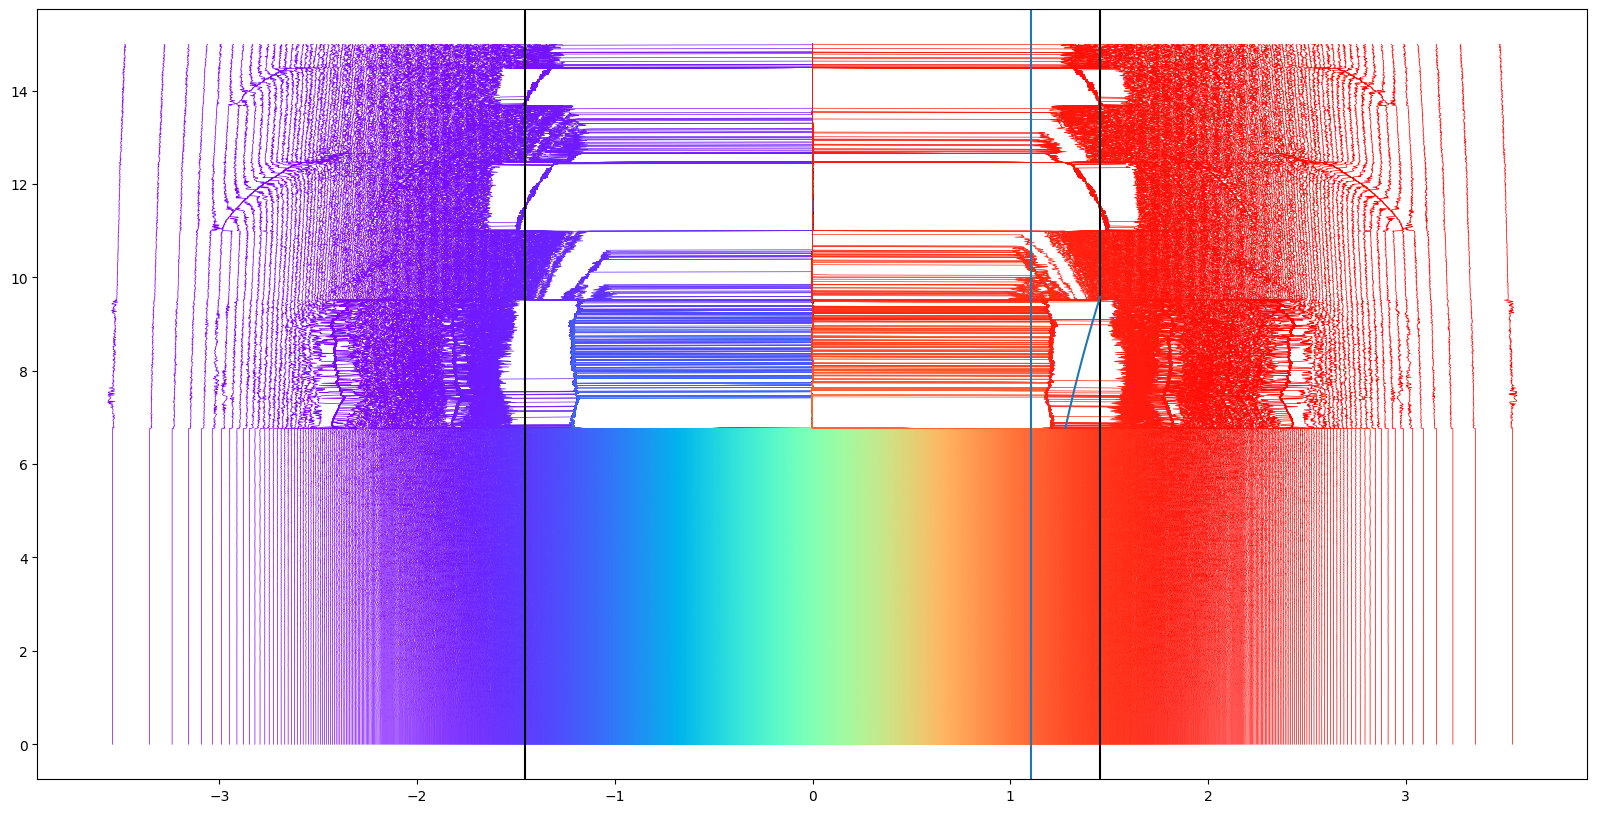

In [79]:
plt.figure(figsize=(20,10))
lw=plt.plot(avg_dthetas['vs'][:],Ks_[:],lw=0.5);
colors = plt.cm.rainbow(np.linspace(0, 1, len(lw)))
for l, c in zip(lw, colors):
    l.set_color(c)
# plt.plot(F_K_OPS(Ks_[:]),Ks_[:],'k--')
# plt.plot(-F_K_OPS(Ks_[:]),Ks_[:],'k--')
plt.axvline(OP)
plt.axvline(OP+delta_P,color='k')
plt.axvline(-(OP+delta_P),color='k')
plt.plot(OP + np.array(delta_Ps),K_con2_)

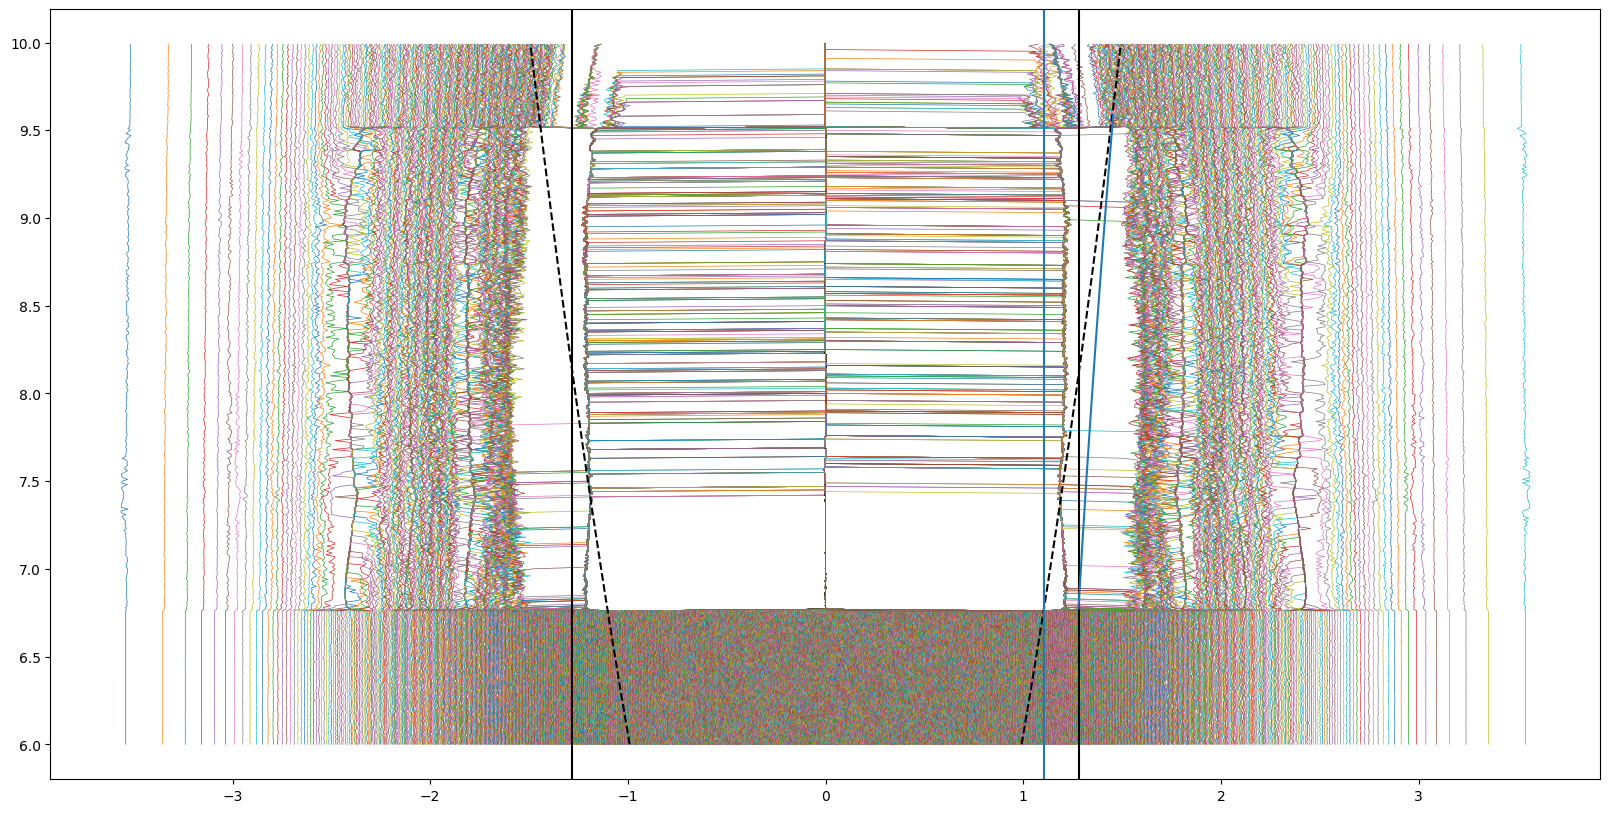

In [585]:
plt.figure(figsize=(20,10))
plt.plot(avg_dthetas['vs'][600:1000],Ks_[600:1000],lw=0.5);
plt.plot(F_K_OPS(Ks_[600:1000]),Ks_[600:1000],'k--')
plt.plot(-F_K_OPS(Ks_[600:1000]),Ks_[600:1000],'k--')
plt.axvline(OP)
plt.axvline(OP+delta_P,color='k')
plt.axvline(-(OP+delta_P),color='k')
plt.plot(OP + np.array(delta_Ps),K_con2_)